In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


In [2]:
def read_logs(fpath):
    f = open(fpath, 'r')
    lines = f.readlines()
    f.close()
    
    data = list( map( lambda s: s.strip().split(), lines) )
    
    df = pl.DataFrame( data,
                       orient ='row',
                       schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                 'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                 'elapsed_time' : pl.Float32, 'max_loss' : pl.Float64, 'min_loss' : pl.Float64 } )

    return df


In [3]:
def make_df():
    py_df = read_logs('./logs/py_log.txt')
    cpp_df = read_logs('./logs/cpp_log.txt')

    df = pl.DataFrame(data = np.zeros( shape= (py_df.shape[0], py_df.shape[1]+3)),
        schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                'cpp_elapsed_time' : pl.Float32, 'cpp_max_loss' : pl.Float64, 'cpp_min_loss' : pl.Float64,
                                'py_elapsed_time' : pl.Float32, 'py_max_loss' : pl.Float64, 'py_min_loss' : pl.Float64} )

    
    df = df.with_columns(
     [pl.lit(cpp_df[c]).alias(c) for c in py_df.columns[:4]] + 
     [pl.lit(cpp_df[c]).alias('cpp_' + c) for c in cpp_df.columns[4:]] +
     [pl.lit(py_df[c]).alias('py_' + c) for c in py_df.columns[4:]]
    )
    
    return df
    

In [4]:
#custom format
def c_f(d,k):
    if k == 'n_epochs':
        return str(d[k][0])
    elif k == 'decay_rate':
        return f"{d[k][0]:.1f}"
    elif k == 'initial_lr':
        return f"{d[k][0]:.2e}"
    elif k == 'regularization_alpha':
        return f"{d[k][0]:.2e}"
        

In [5]:
# hp must be in ["decay_rate", "initial_lr", "regularization_alpha", "n_epochs"]
def plot_lossVShp(df, hp, ix):

    hps = ["decay_rate", "initial_lr", "regularization_alpha", "n_epochs"]
    
    df = df.group_by(
    [x for x in hps if x != hp]).agg(
        pl.col(hp), pl.col("cpp_min_loss"), pl.col("py_min_loss") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | " + " | ".join([ f"{k} : {c_f(d,k)}" for k in d.keys()])
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel(hp)
    ax.set_ylabel('min_loss')
    ax.set_title( title )
    
    ax.plot(data[hp][0], data['cpp_min_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data[hp][0], data['py_min_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [6]:
df = make_df()
df


n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_max_loss,cpp_min_loss,py_elapsed_time,py_max_loss,py_min_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
128,1.0,0.1,0.01,0.212116,0.052932,0.0233311,0.278462,0.097762,0.097732
128,1.0,0.1,0.005,0.231826,0.176766,0.0226428,0.285852,2.0240e6,1.3872e6
128,1.0,0.1,0.001,0.187286,0.111093,0.0218109,0.24547,1.0996e16,4.4440e15
128,1.0,0.1,0.0005,0.181586,0.139241,0.0218398,0.255447,6.8980e16,2.3233e16
128,1.0,0.1,0.0001,0.186608,0.026944,0.021606,0.319497,6.9301e16,1.6262e16
…,…,…,…,…,…,…,…,…,…
4096,0.0001,0.7,0.005,5.92214,0.0810528,0.0802429,7.696448,0.256622,0.037952
4096,0.0001,0.7,0.001,5.64952,0.134694,0.133059,7.475558,0.223738,0.035941
4096,0.0001,0.7,0.0005,5.85705,0.0302584,0.0301617,8.191315,0.263359,0.038333


In [64]:
data = df.filter( (pl.col("cpp_min_loss") < 0.1) & (pl.col("py_min_loss") < 0.1) )
data


n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_max_loss,cpp_min_loss,py_elapsed_time,py_max_loss,py_min_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
128,1.0,0.1,0.01,0.212116,0.052932,0.0233311,0.278462,0.097762,0.097732
128,1.0,0.2,0.01,0.205742,0.0698519,0.0233358,0.276026,0.097407,0.097407
128,1.0,0.2,0.005,0.184611,0.0824948,0.0224699,0.293524,0.090752,0.09074
128,1.0,0.2,0.001,0.264574,0.0452629,0.0219481,0.281455,0.082203,0.081673
128,1.0,0.2,0.0005,0.211757,0.0351601,0.0222052,0.286763,0.087378,0.086172
…,…,…,…,…,…,…,…,…,…
4096,0.0001,0.6,0.00001,6.14416,0.101512,0.0994097,7.169894,0.256194,0.0306
4096,0.0001,0.7,0.01,5.68977,0.0741008,0.0734179,7.27177,0.200232,0.03755
4096,0.0001,0.7,0.005,5.92214,0.0810528,0.0802429,7.696448,0.256622,0.037952


In [65]:
print( f"cpp_loss min  : {data['cpp_min_loss'].min()}")
print( f"cpp_loss mean : {data['cpp_min_loss'].mean()}")
print( f"cpp_loss std  : {data['cpp_min_loss'].std()}")
print()
print( f"py_loss min  : {data['py_min_loss'].min()}")
print( f"py_loss mean : {data['py_min_loss'].mean()}")
print( f"py_loss std  : {data['py_min_loss'].std()}")


cpp_loss min  : 0.0215225
cpp_loss mean : 0.035818572398589064
cpp_loss std  : 0.018806122345190742

py_loss min  : 0.02118225940137088
py_loss mean : 0.03687553593454224
py_loss std  : 0.01731591296221218


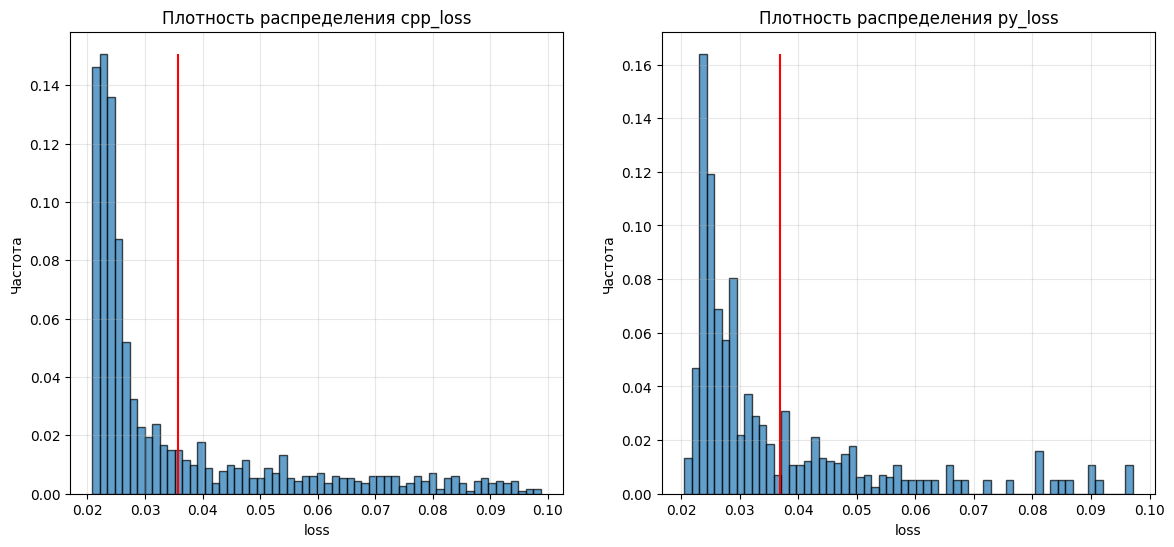

In [108]:
fig2 = plt.figure(figsize=(14, 6))
axes = fig2.subplots(1,2)
cnt_bins = 60
for i,n in zip(range(2), ['cpp','py']):
    
    counts, bins = np.histogram(data[f"{n}_min_loss"], bins=cnt_bins)
    relative_freq = counts / len(data[f"{n}_min_loss"])  
    bin_width = bins[1] - bins[0]
    axes[i].bar(bins[:-1], relative_freq, width=bin_width, alpha=0.7, edgecolor='black')

    axes[i].set_title(f"Плотность распределения {n}_loss")
    axes[i].set_xlabel('loss')
    axes[i].set_ylabel('Частота')
    axes[i].grid(alpha=0.3)
    axes[i].vlines(data[f"{n}_min_loss"].mean(),ymin=0,ymax=max(relative_freq), color='red')
    

In [7]:
n_samples = 3

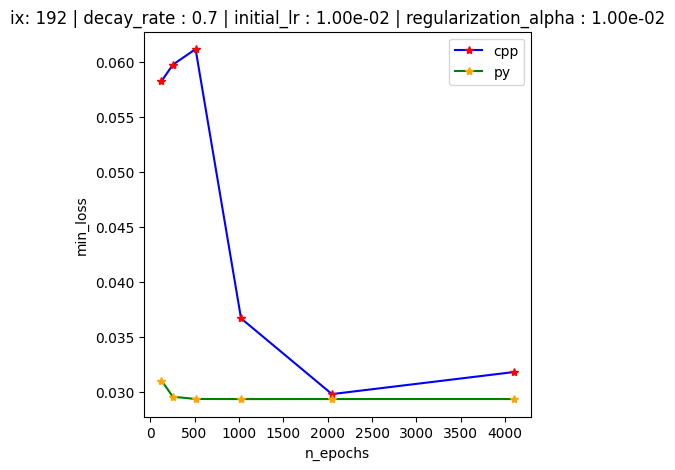

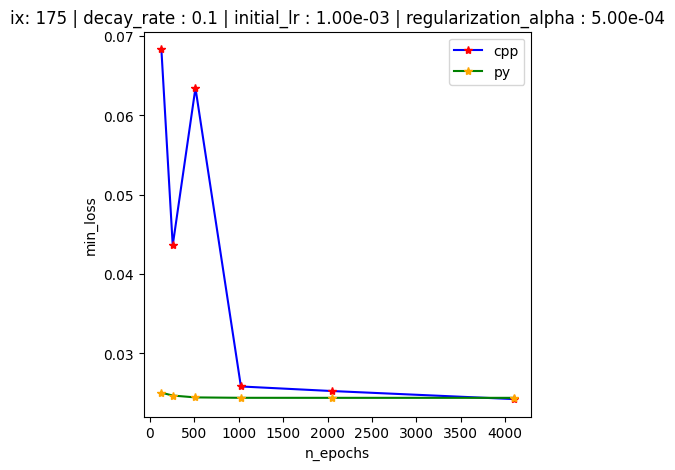

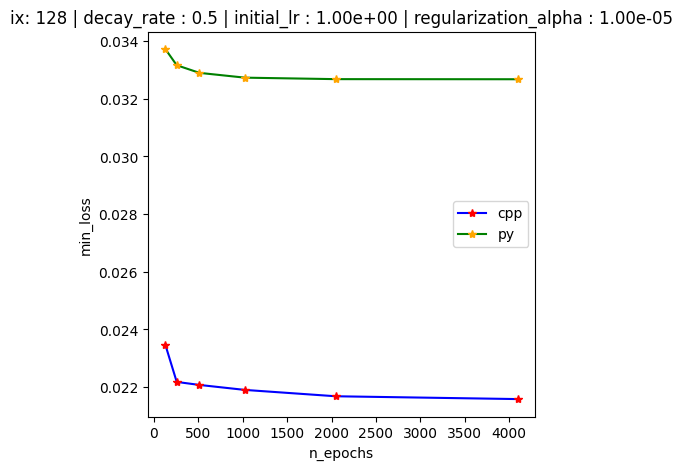

In [36]:
for i in range(n_samples):
    plot_lossVShp(df, "n_epochs", None)

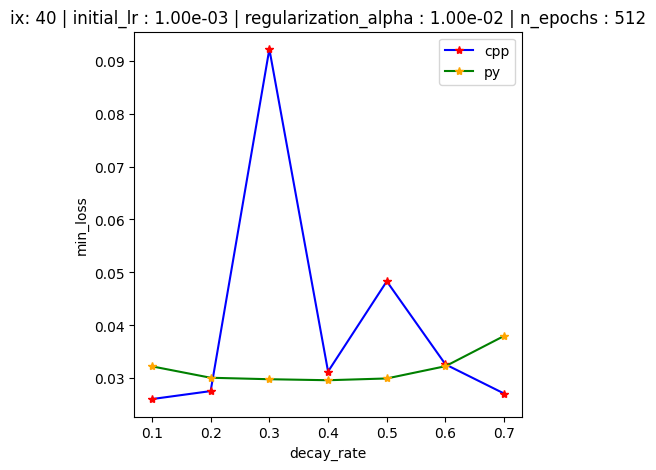

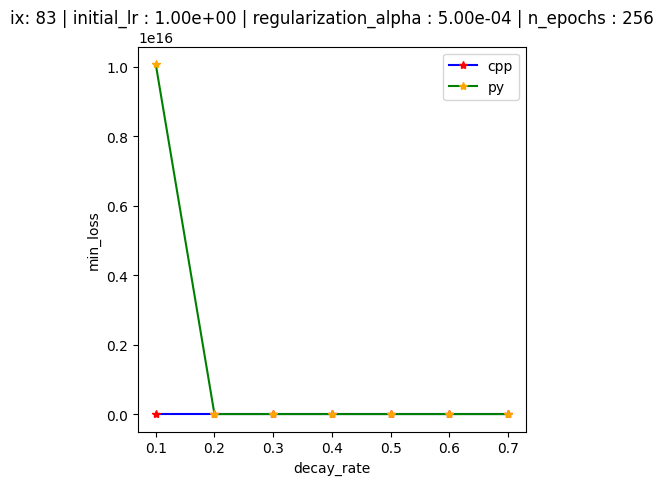

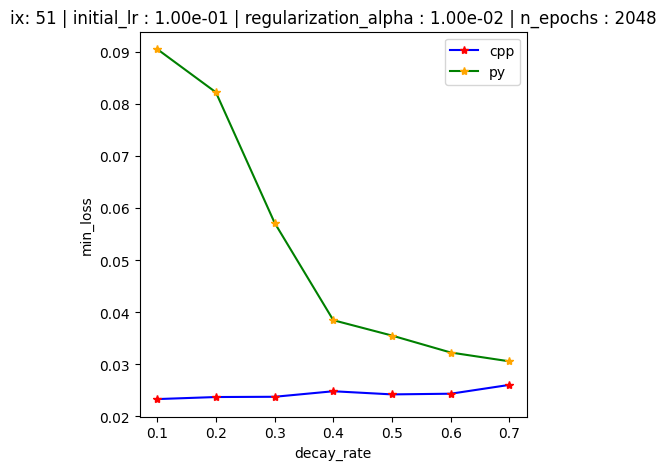

In [25]:
for i in range(n_samples):
    plot_lossVShp(df, "decay_rate", None)

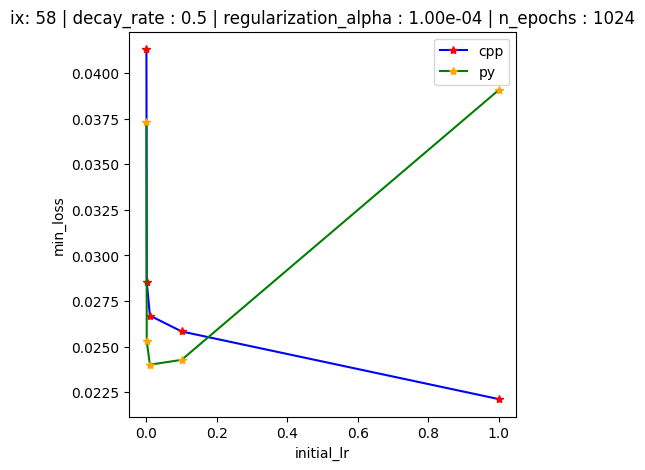

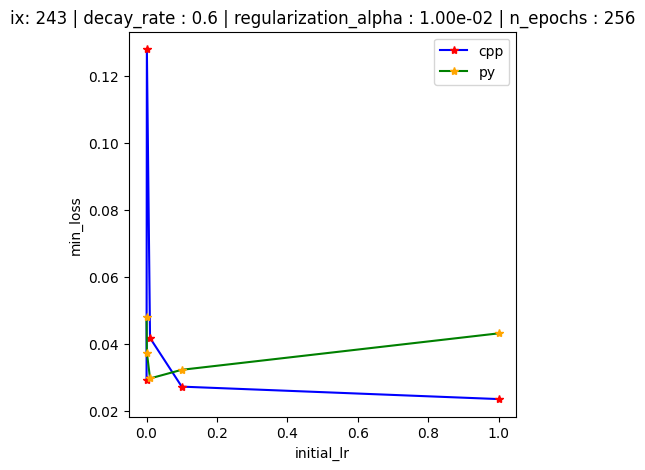

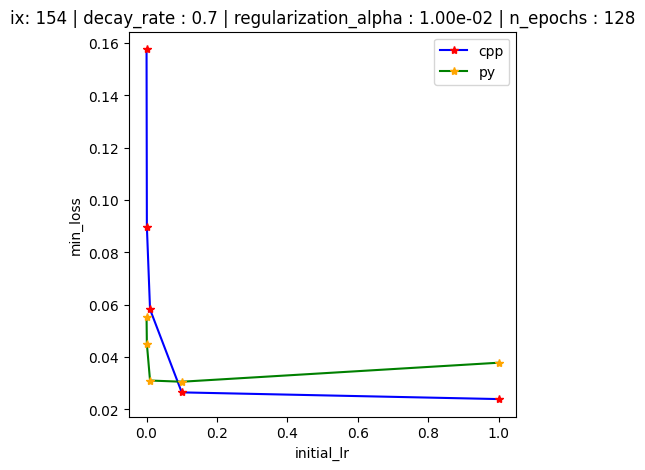

In [34]:
for i in range(n_samples):
    plot_lossVShp(df, "initial_lr", None)

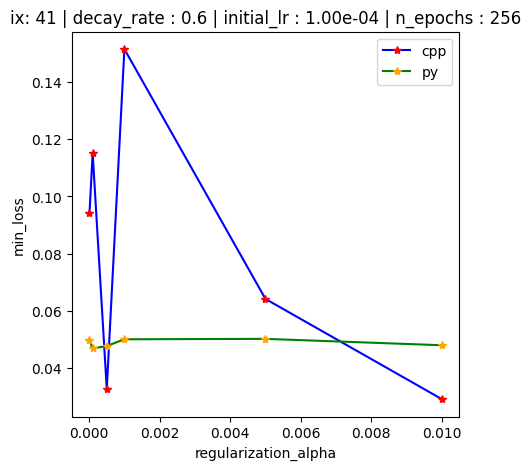

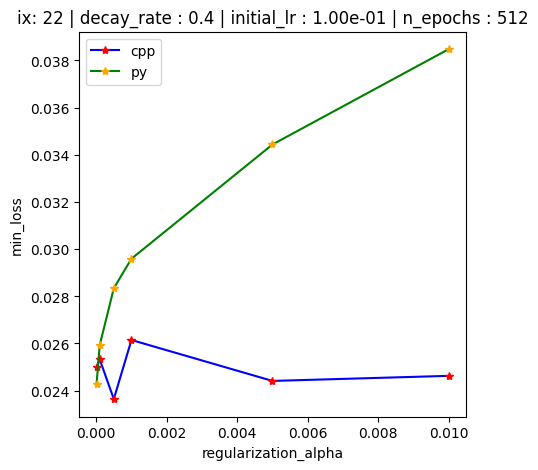

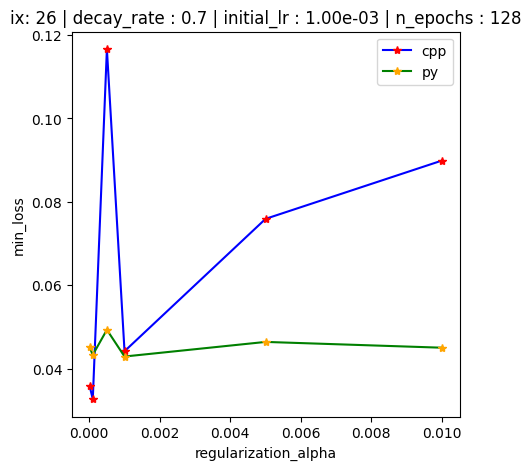

In [27]:
for i in range(n_samples):
    plot_lossVShp(df, "regularization_alpha", None)